In [1]:
%load_ext autoreload 
%autoreload 2

import operator
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '../') # The following modules are in the directory above
from cohort_model import (
    run_cohort_simulation, 
    HYP_WILDTYPE,
    MUT_CAPTIVITY,
    MUT_WILD
)
from figures import ROOT_DIR

# Parameter estimation for case study 2 (*Telostylinus angusticollis*)

## Estimating $\alpha$ and $\kappa$

**Note:** The $\alpha$ and $\kappa$ values (for females and males) used in figure 4 were obtained during an earlier least squares fitting. In restructuring the code for publication we have also improved the fitting procedure and obtained new and better values. However, these are not used in the figure in order to produce results matching those in the published paper (which could not be updated by the time we obtained the better fit).

In [2]:
# Simulation parameters
individual_count = 1000
repetition_count = 100 

t_m_f = 326 # Max t for curve fitting (last x data point = 325)
t_m_m = 291 # Max t for curve fitting (last x data point = 290)

In [3]:
# FEMALES
x_captivity_f = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/captivity_females_x.txt')
y_captivity_f = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/captivity_females_y.txt')

xdata_f = np.round(x_captivity_f).astype('int64') # In order to use for indexing
ydata_f = y_captivity_f * individual_count

# MALES
x_captivity_m = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/captivity_males_x.txt')
y_captivity_m = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/captivity_males_y.txt')

xdata_m = np.round(x_captivity_m).astype('int64') # In order to use for indexing
ydata_m = y_captivity_m * individual_count

In [4]:
%%time
# FEMALES, least squares
n = len(xdata_f)

fit = []
for alpha in np.arange(0.0028, 0.0030, 0.0001): 
    for kappa in np.arange(0.0084, 0.0085, 0.0001): 
        hazard_rate_params = dict(alpha=alpha, kappa=kappa, population=MUT_CAPTIVITY)
        population_survivorship = run_cohort_simulation(
            repetition_count, 
            individual_count, 
            hazard_rate_params, 
            t_m_f,   
        )
        mean = np.mean(population_survivorship, axis=0)[xdata_f]
        squares = [(mean[i] - ydata_f[i])**2 for i in range(n)]
        fit.append((alpha, kappa, sum(squares)))
        
best_fits = sorted(fit, key=operator.itemgetter(2))
print('alpha, kappa, sum squares (females)')
print(*best_fits[0:10], sep='\n')

alpha, kappa, sum squares (females)
(0.0029, 0.0084, 1154.8243000000007)
(0.0029, 0.008499999999999999, 1195.1354999999985)
(0.0028, 0.008499999999999999, 1314.1561999999994)
(0.0029999999999999996, 0.0084, 1784.2904000000024)
(0.0028, 0.0084, 2256.3816)
(0.0029999999999999996, 0.008499999999999999, 2463.0410000000015)
CPU times: user 1min 44s, sys: 1min 55s, total: 3min 39s
Wall time: 4min 22s


In [5]:
%%time
# MALES, least squares
n = len(xdata_m)

fit = []
for alpha in np.arange(0.00056, 0.00058, 0.00001): 
    for kappa in np.arange(0.0172, 0.0174, 0.0001): 
        hazard_rate_params = dict(alpha=alpha, kappa=kappa, population=MUT_CAPTIVITY)
        population_survivorship = run_cohort_simulation(
            repetition_count, 
            individual_count, 
            hazard_rate_params, 
            t_m_m, 
        )
        mean = np.mean(population_survivorship, axis=0)[xdata_m]
        squares = [(mean[i] - ydata_m[i])**2 for i in range(n)]
        fit.append((alpha, kappa, sum(squares)))
        
best_fits = sorted(fit, key=operator.itemgetter(2))
print('alpha, kappa, sum squares (males)')
print(*best_fits[0:10], sep='\n')

alpha, kappa, sum squares (males)
(0.00057, 0.0173, 519.0083000000002)
(0.00057, 0.0172, 630.0872000000013)
(0.00056, 0.0173, 640.3186999999987)
(0.00058, 0.0172, 657.4858999999997)
(0.00058, 0.0173, 887.0013000000015)
(0.00056, 0.0172, 968.8162000000013)
CPU times: user 1min 18s, sys: 1min 23s, total: 2min 41s
Wall time: 3min


### Estimating $\epsilon$ and $h_{wt}(t)$

In [6]:
# FEMALES
x_wild_f = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_females_x.txt')
y_wild_f = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_females_y.txt')

x_wild_f = np.round(x_wild_f).astype('int64') # In order to use for indexing
y_wild_f = y_wild_f * individual_count

x_wild_f = x_wild_f[:-2] # In order not to fit to the last two data points
y_wild_f = y_wild_f[:-2] # In order not to fit to the last two data points

# MALES
x_wild_m = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_males_x.txt')
y_wild_m = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_males_y.txt')

x_wild_m = np.round(x_wild_m).astype('int64') # In order to use for indexing
y_wild_m = y_wild_m * individual_count

x_wild_m = x_wild_m[:-2] # In order not to fit to the last two data points
y_wild_m = y_wild_m[:-2] # In order not to fit to the last two data points

In [7]:
%%time
# FEMALES, least squares
t_m_wild_f = 100
n = len(x_wild_f)

fit = []
# TODO: The population is set to the hypothetical wild type, in order to use the 
for prod_wt_f in np.arange(0.046, 0.051, 0.001): # prod_wt = (1 - epsilon) * h_wt
    hazard_rate_params = dict(hazard_rate_hypwt=prod_wt_f, population=HYP_WILDTYPE) 
    population_survivorship = run_cohort_simulation(
        repetition_count, 
        individual_count, 
        hazard_rate_params, 
        t_m_wild_f,
    )
    mean = np.mean(population_survivorship, axis=0)[x_wild_f]
    squares = [(mean[i] - y_wild_f[i])**2 for i in range(n)] # Not fitting to last two data points
    fit.append((prod_wt_f, sum(squares)))

best_fits_f = sorted(fit, key=operator.itemgetter(1))
print('prod_wt, sum squares (females)')
print(*best_fits_f[0:10], sep='\n')
print()

prod_wt_f = best_fits_f[0][0]
for epsilon in np.arange(0.01, 0.05, 0.01):
    h_wt = prod_wt_f / (1 - epsilon)
    print(f'epsilon = {epsilon}, h_wt_f = {h_wt}')

prod_wt, sum squares (females)
(0.05, 938.5554999999972)
(0.049, 1584.9529999999954)
(0.048, 2186.0851999999986)
(0.047, 3438.0354000000043)
(0.046, 4068.537700000001)

epsilon = 0.01, h_wt_f = 0.05050505050505051
epsilon = 0.02, h_wt_f = 0.05102040816326531
epsilon = 0.03, h_wt_f = 0.051546391752577324
epsilon = 0.04, h_wt_f = 0.052083333333333336
CPU times: user 9.73 s, sys: 7.53 s, total: 17.3 s
Wall time: 19.8 s


In [8]:
%%time
# MALES, least squares
t_m_wild_m = 53 # TODO: Korrekt?
n = len(x_wild_m)

fit = []
for prod_wt_m in np.arange(0.043, 0.044, 0.0001): # prod_wt = (1 - epsilon) * h_wt
    hazard_rate_params = dict(hazard_rate_hypwt=prod_wt_m, population=HYP_WILDTYPE)
    population_survivorship = run_cohort_simulation(
        repetition_count, 
        individual_count, 
        hazard_rate_params, 
        t_m_wild_m,
    )
    mean = np.mean(population_survivorship, axis=0)[x_wild_m]
    squares = [(mean[i] - y_wild_m[i])**2 for i in range(n)] # Not fitting to last two data points
    fit.append((prod_wt_m, sum(squares)))

best_fits_m = sorted(fit, key=operator.itemgetter(1))
print('prod_wt, sum squares (males)')
print(*best_fits_m[0:10], sep='\n')
print()

prod_wt_m = best_fits_m[0][0]
for epsilon in np.arange(0.01, 0.05, 0.01):
    h_wt = prod_wt_m / (1 - epsilon)
    print(f'epsilon = {epsilon}, h_wt_m = {h_wt}')

prod_wt, sum squares (males)
(0.04390000000000002, 2013.533)
(0.044000000000000025, 2088.5169000000024)
(0.04370000000000002, 2100.6717999999983)
(0.0432, 2137.9075999999995)
(0.043600000000000014, 2158.1651000000015)
(0.04380000000000002, 2183.2758000000035)
(0.043300000000000005, 2234.047400000005)
(0.043, 2242.0629999999983)
(0.04350000000000001, 2267.1160999999965)
(0.04340000000000001, 2412.368100000005)

epsilon = 0.01, h_wt_m = 0.044343434343434365
epsilon = 0.02, h_wt_m = 0.04479591836734696
epsilon = 0.03, h_wt_m = 0.04525773195876291
epsilon = 0.04, h_wt_m = 0.04572916666666669
CPU times: user 7.41 s, sys: 4.01 s, total: 11.4 s
Wall time: 12 s


## Estimating $\omega$ and $\tau$

A phenomenological extra morality term was needed for wild males. The term consists of parameters $\omega$ and $\tau$ which are estimated below.

In [9]:
# Wild male simulation parameters
individual_count = 1000
repetition_count = 100

t_m_wild_m = 54  # Max t for curve fitting (last x data point = 53)

epsilon = 0.04

# The following three values are from an earlier parameter estimation, see note in top of notebook
hazard_rate_hypwt = 0.0453 
alpha_m = 0.00057
kappa_m = 0.0173

# Target parameters, these have been estimated iteratively in a manual fashion
omega = 0.0001
tau = 1.8 

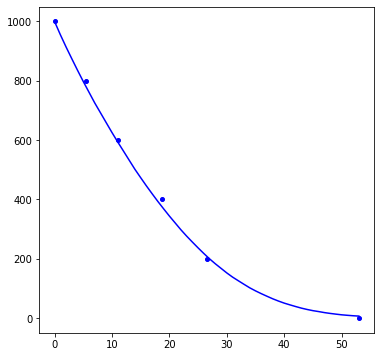

In [10]:
# Run simulation and calculate mean
hazard_rate_params = dict(alpha=alpha_m, kappa=kappa_m, omega=omega, tau=tau, epsilon=epsilon, hazard_rate_hypwt=hazard_rate_hypwt, population=MUT_WILD)
survivorship_wild_m = run_cohort_simulation(repetition_count, individual_count, hazard_rate_params, t_m_wild_m)
wild_mean = np.mean(survivorship_wild_m, axis=0)

# Inspect quality of fit
wild_m_x = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_males_x.txt')
wild_m_y = np.genfromtxt(f'{ROOT_DIR}/data/kawasaki_2008/wild_males_y.txt')
wild_m_y = wild_m_y * individual_count

t_steps = np.arange(t_m_wild_m) 

fig1, ax = plt.subplots(figsize=(6, 6))
ax.plot(wild_m_x, wild_m_y, 'bo', markersize=4)                                 
ax.plot(t_steps, wild_mean, 'b-')